In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

ModuleNotFoundError: No module named 'google.colab'

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [5]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [19]:
y_test

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0,
       4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6,
       0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2,
       1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7,
       8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7,
       4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1,
       8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0,
       0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9,
       3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8,
       7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2,
       7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1,
       8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7,
       0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9,
       1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6,

## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [14]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 1190.636463
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [15]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1358.865444 analytic: 21387.422306, relative error: 8.805198e-01
numerical: -659.049611 analytic: -8266.413881, relative error: 8.523215e-01
numerical: -904.625868 analytic: -7418.897964, relative error: 7.826339e-01
numerical: -942.243835 analytic: -11033.944337, relative error: 8.426471e-01
numerical: 717.927612 analytic: 2141.773371, relative error: 4.979002e-01
numerical: -872.850025 analytic: -7164.773759, relative error: 7.828089e-01
numerical: -418.767754 analytic: -2194.864802, relative error: 6.795512e-01
numerical: 443.827773 analytic: 2795.489382, relative error: 7.259745e-01
numerical: 201.872278 analytic: 1983.257002, relative error: 8.152308e-01
numerical: -49.445767 analytic: 235.213568, relative error: 1.000000e+00
numerical: 264.415620 analytic: 6231.886565, relative error: 9.185950e-01
numerical: -933.248905 analytic: -7867.298157, relative error: 7.879112e-01
numerical: 1381.436091 analytic: 10654.813845, relative error: 7.704541e-01
numerical: 0.482341 an

In [27]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.381273e+00 computed in 0.078516s
vectorized loss: 2.381589e+00 computed in 0.002793s
Loss difference: 0.000316
Gradient difference: 3185.150451


In [33]:
# from cs231n.classifiers import Softmax
from cs231n.classifiers import LinearSVM


In [39]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 2e-6, 2.5e-6]
regularization_strengths = [1e3, 1e4, 2e4, 2.5e4, 3e4, 3.5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for i in learning_rates:
    for j in regularization_strengths:
        soft_max = Softmax()
        loss_comb = soft_max.train(X_train, y_train, i, j,
                      num_iters=1500, verbose=True)
        y_train_pred = soft_max.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred =soft_max.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(i,j)] = (train_accuracy, val_accuracy)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_softmax = soft_max





pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****




    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 1005.162677
iteration 100 / 1500: loss 1003.906769
iteration 200 / 1500: loss 1003.705602
iteration 300 / 1500: loss 1003.441756
iteration 400 / 1500: loss 1003.066196
iteration 500 / 1500: loss 1003.048260
iteration 600 / 1500: loss 1002.926588
iteration 700 / 1500: loss 1002.699451
iteration 800 / 1500: loss 1002.488276
iteration 900 / 1500: loss 1002.725172
iteration 1000 / 1500: loss 1002.294565
iteration 1100 / 1500: loss 1002.384509
iteration 1200 / 1500: loss 1002.580178
iteration 1300 / 1500: loss 1002.425869
iteration 1400 / 1500: loss 1002.201890
iteration 0 / 1500: loss 10006.821531
iteration 100 / 1500: loss 10003.709944
iteration 200 / 1500: loss 10002.827917
iteration 300 / 1500: loss 10002.578998
iteration 400 / 1500: loss 10002.205936
iteration 500 / 1500: loss 10002.183184
iteration 600 / 1500: loss 10002.087350
iteration 700 / 1500: loss 10002.007967
iteration 800 / 1500: loss 10002.070203
iteration 900 / 1500: loss 10001.843715
iteration 1000

iteration 1100 / 1500: loss 10001.946406
iteration 1200 / 1500: loss 10001.893926
iteration 1300 / 1500: loss 10001.883920
iteration 1400 / 1500: loss 10001.976705
iteration 0 / 1500: loss 20005.196804
iteration 100 / 1500: loss 20001.910911
iteration 200 / 1500: loss 20002.019012
iteration 300 / 1500: loss 20002.001245
iteration 400 / 1500: loss 20001.973749
iteration 500 / 1500: loss 20001.972336
iteration 600 / 1500: loss 20001.981637
iteration 700 / 1500: loss 20001.998825
iteration 800 / 1500: loss 20001.947919
iteration 900 / 1500: loss 20001.950281
iteration 1000 / 1500: loss 20002.038274
iteration 1100 / 1500: loss 20001.929647
iteration 1200 / 1500: loss 20002.068475
iteration 1300 / 1500: loss 20002.043179
iteration 1400 / 1500: loss 20002.013371
iteration 0 / 1500: loss 25006.298900
iteration 100 / 1500: loss 25002.042238
iteration 200 / 1500: loss 25001.950816
iteration 300 / 1500: loss 25002.062101
iteration 400 / 1500: loss 25002.038852
iteration 500 / 1500: loss 25002.03

In [40]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.396000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



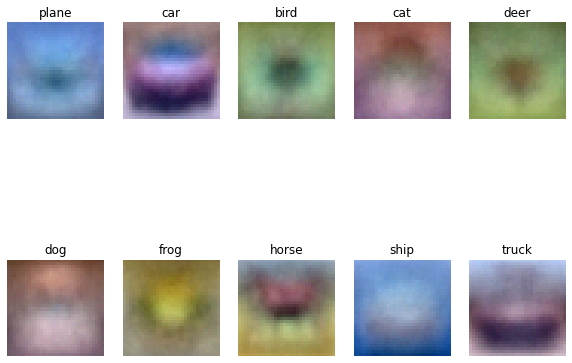

In [38]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])